The goal of this notebook is to **use Google's GTFS data to find out how many trains are operating in the NYC Subway at any given time**. Along the way, we will also how frequency changes throughout the train schedule and examine how frequency interacts with ridership numbers.

[MTA Developer Tools](https://new.mta.info/developers). The google data for the mta should be all that we need. There's weekday, saturday, and sunday service so only need to worry about those times. Additionally, there's data on the buses, LIRR and Metro North in there, too.
- [mta metrics dashboard](https://metrics.mta.info/?subway/customerjourneytimeperformance)

[time frequency](https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_services#Train_frequency_charts) breakdown

Some notes about the results:
- the routes change by day of week (for example the M not running its whole route on the weekends)
- some routes include service changes (the 7 and 7 express both count as the 7)
- this also includes late nights where the routes can change dramatically (e.g.: the 5 train doesn't leave the BX at night)
- two routes don't run on the weekends: the B and W

# Imports

In [1]:
import pandas as pd
import geopandas as gpd
from geodatasets import get_path
import shapely
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import os
import sys
import glob
# from natsort import natsorted #using this to sort files numerically instead of alphabetically
import imageio
from PIL import Image
import warnings
warnings.filterwarnings(action='ignore')
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import tab20
mpl.rcParams['figure.dpi'] = 300

In [2]:
# getting functions from the parent directory
library_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if library_path not in sys.path:
    sys.path.append(library_path)
from functions import *

# Schedule Data

In [3]:
routes_df = pd.read_csv("../data/google_transit/routes.txt")
stop_times_df = pd.read_csv("../data/google_transit/stop_times.txt")
stops_df = pd.read_csv("../data/google_transit/stops.txt")

## Frequency Data 
(that I made)

In [4]:

trip_interval_route_freq = pd.read_csv("../saved_data/trip_interval_route_freq.csv", index_col=0)
route_frequency_by_day = pd.read_csv("../saved_data/route_frequency_by_day.csv", index_col=0)
station_info_w_frequency = pd.read_csv("../saved_data/station_info_w_frequency.csv", index_col=0)
stations_df = pd.read_csv("../saved_data/stations_df.csv", index_col=0)
orig_stations_df = pd.read_csv("../data/MTA_Subway_Stations_20240325.csv", index_col=0)
station_complex_full_info = pd.read_csv("../saved_data/station_info_w_frequency.csv", index_col=0)

In [5]:
# sorting the trip interval data by service
# sorting train_time_interval by time of day
time_of_day_sorting = {'Late Night': 0, 'Rush Hour AM': 1, 'Midday': 2
                                     , 'Rush Hour PM': 3, 'Evening': 4, 'Weekend': 5}
trip_interval_route_freq = trip_interval_route_freq.sort_values(by= ['route_id', 'train_time_interval']
                                    , key=lambda x: x.map(time_of_day_sorting)).reset_index(drop=True)

## Mapping GeoDataFrame

In [6]:
path_to_file = get_path('nybb')
boros = gpd.read_file(path_to_file).to_crs(epsg=3857)
# boros = boros.to_crs(epsg=3857)

## Removing SIR 

In [7]:
station_info_w_frequency = station_info_w_frequency[station_info_w_frequency['Borough']!='SI']
stations_df = stations_df[stations_df['Borough']!='SI']
orig_stations_df = orig_stations_df[orig_stations_df['Borough']!='SI']
station_complex_full_info = station_complex_full_info[station_complex_full_info['Borough']!='SI']
boros = boros[boros['BoroName']!='Staten Island']
# boros.drop(5, inplace=True) #removing staten island

# GeoData Transformations

In [8]:
orig_stations_df['GTFS Latitude'] = [x.split(" ")[1][1:] for x in orig_stations_df['Georeference']]
orig_stations_df['GTFS Longitude'] = [x.split(" ")[2][:-1] for x in orig_stations_df['Georeference']]
geometries = [shapely.Point(x,y) for x,y in list(zip(orig_stations_df['GTFS Latitude'], orig_stations_df['GTFS Longitude']))]
orig_stations_df['geometries'] = geometries

In [9]:
orig_stations_gdf = gpd.GeoDataFrame(orig_stations_df, geometry='geometries')
orig_stations_gdf = orig_stations_gdf.set_crs(epsg=4326).to_crs(epsg=3857)
# .set_crs(epsg=4326).to_crs(epsg=3857)

In [10]:
# adding the rank of the station in terms of trains per hour on a 1-10 scale
station_complex_full_info['TPH_percent_rank'] = station_complex_full_info['trains_per_hour'].rank(pct=True)
# station_complex_full_info['Ridership_percent_rank'] = station_complex_full_info['avg_hourly_ridership'].rank(pct=True)
# station_complex_full_info['Crowdedness_percent_rank'] = station_complex_full_info['hourly_ridership_per_train_direction'].rank(pct=True)
stations_geodataframe = gpd.GeoDataFrame(station_complex_full_info
                                        , geometry=geometries).set_crs(epsg=4326).to_crs(epsg=3857)
# stations_geodataframe = stations_geodataframe.set_crs(epsg=4326)

In [11]:
complex_geodataframe = stations_geodataframe.dissolve(by='Complex ID',aggfunc='sum').reset_index()
complex_geodataframe['geometry'] = complex_geodataframe.geometry.centroid
complex_geodataframe = complex_geodataframe

In [12]:
complex_geodataframe.columns

Index(['Complex ID', 'geometry', 'GTFS Stop ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'Daytime Routes', 'Structure',
       'stations_in_complex_count', 'trains_per_hour', 'hourly_trainset_area',
       'capacity', 'mean_wait_time', 'Late Night', 'Weekend', 'Rush Hour AM',
       'Midday', 'Rush Hour PM', 'Evening', 'TPH_percent_rank'],
      dtype='object')

In [13]:
complex_geodataframe.columns = ['Complex ID', 'geometry', 'GTFS Stop ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'Daytime Routes', 'Structure',
       'stations_in_complex_count', 'tph', 'hourly_trainset_area',
       'capacity', 'mean_wait_time', 'Late Night', 'Weekend', 'Rush Hour AM',
       'Midday', 'Rush Hour PM', 'Evening', 'TPH_percent_rank']

In [14]:
# # updating the locations to be for the complex and not the station
# stations_df['GTFS Longitude'] = [complex_df.loc[complex_df['Complex ID'] == x]['GTFS Longitude'].values[0] 
#                                  for x in stations_df['Complex ID']]
# stations_df['GTFS Latitude'] = [complex_df.loc[complex_df['Complex ID'] == x]['GTFS Latitude'].values[0] 
#                                  for x in stations_df['Complex ID']]
# stations_geodataframe_updated = gpd.GeoDataFrame(stations_df
#                                         , geometry=gpd.points_from_xy(stations_df['GTFS Longitude']
#                                                                      , stations_df['GTFS Latitude']))
# stations_geodataframe_updated = stations_geodataframe_updated.set_crs(epsg=4326).to_crs(epsg=3857)

# Getting TPH for each Station
note that we're using stations for this analysis and not complexes

## Overall (non late night) Frequency

In [15]:
station_info_w_frequency

,GTFS Stop ID,Complex ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,stations_in_complex_count,trains_per_hour,hourly_trainset_area,capacity,mean_wait_time,Late Night,Weekend,Rush Hour AM,Midday,Rush Hour PM,Evening
0,101,293,IRT,Broadway - 7Av,Van Cortlandt Park-242 St,Bx,1,Elevated,1,10,"4,124",982,6,4,8,8,11,13,10
1,103,294,IRT,Broadway - 7Av,238 St,Bx,1,Elevated,1,10,"4,266","1,016",6,4,8,10,11,14,10
2,104,295,IRT,Broadway - 7Av,231 St,Bx,1,Elevated,1,10,"4,266","1,016",6,4,8,10,11,14,10
3,106,296,IRT,Broadway - 7Av,Marble Hill-225 St,M,1,Elevated,1,10,"4,275","1,018",6,4,8,10,11,14,10
4,107,297,IRT,Broadway - 7Av,215 St,M,1,Elevated,1,10,"4,308","1,026",6,4,8,10,11,14,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,R44,38,BMT,4th Av,86 St,Bk,R,Subway,1,6,"3,674",875,9,3,5,8,8,8,6
471,R45,39,BMT,4th Av,Bay Ridge-95 St,Bk,R,Subway,1,6,"3,678",876,9,3,5,8,8,8,6
472,S01,627,BMT,Franklin Shuttle,Franklin Av,Bk,S,Elevated,2,5,750,179,11,3,5,6,6,6,4
473,S03,141,BMT,Franklin Shuttle,Park Pl,Bk,S,Open Cut,1,5,750,179,11,3,5,6,6,6,4


Text(0, 0.5, 'Trains per Hour')

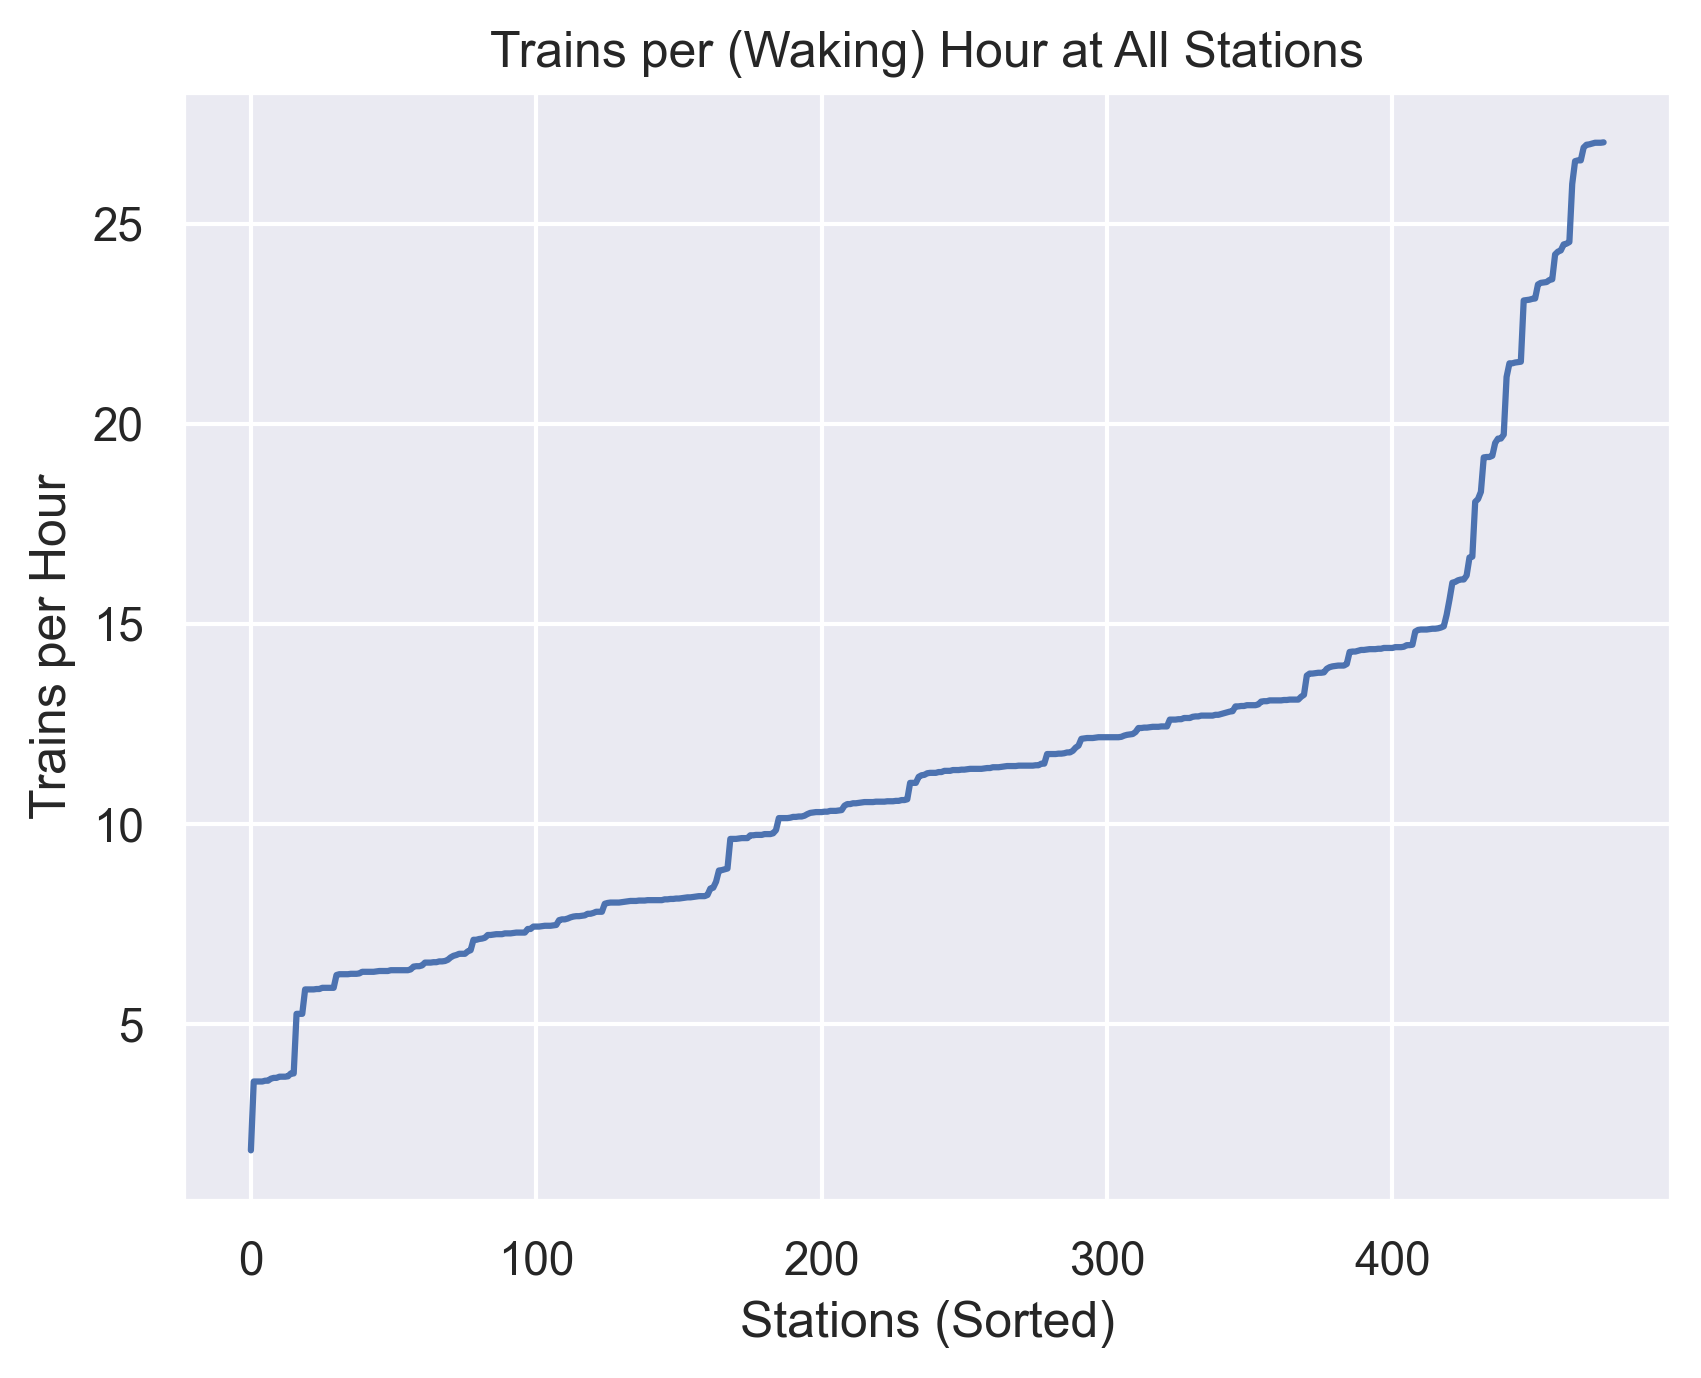

In [16]:
ax = station_info_w_frequency['trains_per_hour'].sort_values().plot(
    use_index=False, title="Trains per (Waking) Hour at All Stations")
ax.set_xlabel('Stations (Sorted)')
ax.set_ylabel('Trains per Hour')
# plt.savefig("saved_data/station_tph.png") 

### By Line 

In [17]:
# getting the average tph by line 
frequency_by_line = pd.DataFrame(station_info_w_frequency.groupby('Line')
                                 .mean()).sort_values(by='trains_per_hour')
frequency_by_line = frequency_by_line.drop(columns=['Complex ID', 'stations_in_complex_count', 'hourly_trainset_area'
                                            , 'capacity', 'mean_wait_time']).round(1).reset_index()

TypeError: agg function failed [how->mean,dtype->object]

In [241]:
ax = frequency_by_line['trains_per_hour'].sort_values().plot(
    use_index=False, title="Trains per (Waking) Hour for All Lines")
ax.set_xlabel('Lines (Sorted)')
ax.set_ylabel('Trains per Hour')
# plt.savefig("saved_data/lines_tph.png") 

NameError: name 'frequency_by_line' is not defined

### Mapping the Lines

In [242]:
num_categories = stations_df['Line'].nunique()
colors = [tab20(float(i)/num_categories) for i, _ in enumerate(stations_df['Line'].unique())]
hex_colors = [mpl.colors.rgb2hex(x, keep_alpha=True) for x in colors]
line_hex_colors = dict(zip(list(stations_df['Line'].unique()), hex_colors))

In [243]:
# I need to use folium for the map with circles
lines_map = folium.folium.Map([40.7128, -74.0061], zoom_start=10, tiles='cartodbpositron') # city hall coords
for idx in range(len(stations_df)):
     folium.Circle(
            location = (stations_df['GTFS Latitude'][idx], stations_df['GTFS Longitude'][idx]),
            radius = 150, 
            tooltip = stations_df['Line'][idx], 
            popup = stations_df['Stop Name'][idx],
#          TPH {station_complex_full_info.ridership[idx]} Riders per day"
            color=line_hex_colors[stations_df['Line'][idx]],
            fill=True,
            fill_opacity= 0.3
        ).add_to(lines_map)
# lines_map.save("./saved_data/Lines_map.html")

In [244]:
lines_map

### Plotting the Change in Frequency by Train Time Interval

In [245]:
for interval in time_of_day_sorting.keys():
    ax = sns.barplot(data=frequency_by_line.sort_values(by=interval)
                                 , x = 'Line', y=interval)
#     ax.title(interval)
    ax.grid(axis='y')
    ax.set_ylim(ymin=0, ymax=30)
    ax.set_ylabel('Trains per Hour')
    ax.set_title(interval)
    plt.xticks(rotation=270)
    plt.show()

NameError: name 'frequency_by_line' is not defined

In [22]:
frequency_by_line

,Line,trains_per_hour,Late Night,Weekend,Rush Hour AM,Midday,Rush Hour PM,Evening
0,Rockaway,3.8,3.1,3.1,4.8,4.0,4.8,3.3
1,Franklin Shuttle,5.3,3.0,4.9,6.0,6.0,6.0,4.2
2,63rd St,5.4,1.8,5.2,5.9,5.5,6.1,5.3
3,Myrtle Av,5.8,3.4,6.0,6.0,6.0,6.0,5.9
4,Liberty Av,5.8,4.7,4.6,7.9,6.0,7.6,5.3
5,West End,5.9,3.3,4.9,7.4,6.2,7.2,5.5
6,Dyre Av,6.1,3.2,4.8,6.0,7.9,7.3,5.6
7,Sea Beach,6.3,3.3,4.9,7.3,7.7,7.8,5.0
8,Crosstown,6.8,3.2,6.2,7.8,7.5,7.6,6.2
9,Concourse,7.1,3.4,4.9,11.1,6.7,10.2,6.1


# X Minute City 
What parts of nyc have subway accessibility?

In [18]:
complex_geodataframe

,Complex ID,geometry,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,stations_in_complex_count,...,hourly_trainset_area,capacity,mean_wait_time,Late Night,Weekend,Rush Hour AM,Midday,Rush Hour PM,Evening,TPH_percent_rank
0,1,POINT (-8227379.441 4985311.546),R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,1,...,"5,496","1,309",6,3,5,12,13,13,8,0
1,2,POINT (-8228487.07 4985255.504),R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,1,...,"5,496","1,309",6,3,5,12,13,13,8,0
2,3,POINT (-8229484.604 4985593.965),R04,BMT,Astoria,30 Av,Q,N W,Elevated,1,...,"5,496","1,309",6,3,5,12,13,13,8,0
3,4,POINT (-8230570.191 4986398.609),R05,BMT,Astoria,Broadway,Q,N W,Elevated,1,...,"5,507","1,311",6,3,5,12,13,13,8,0
4,5,POINT (-8230545.145 4985889.778),R06,BMT,Astoria,36 Av,Q,N W,Elevated,1,...,"5,505","1,311",6,3,5,12,13,13,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,628,POINT (-8224338.276 4968835.699),229418A38M22,IRTIRTINDBMT,Clark StLexington Av8th Av - Fulton StJamaica,Fulton StFulton StFulton StFulton St,MMMM,2 34 5A CJ Z,SubwaySubwaySubwaySubway,16,...,"24,766","5,897",18,15,39,71,62,70,44,3
420,629,POINT (-8231117.995 4978063.688),G29L10,INDBMT,CrosstownCanarsie,Metropolitan AvLorimer St,BkBk,GL,SubwaySubway,4,...,"9,581","2,281",9,10,24,31,27,29,24,1
421,630,POINT (-8233178.407 4979057.786),L17M08,BMTBMT,CanarsieMyrtle Av,Myrtle-Wyckoff AvsMyrtle-Wyckoff Avs,BkBk,LM,SubwayElevated,4,...,"8,972","2,136",14,7,18,23,21,22,18,1
422,635,POINT (-8233456.762 4965921.366),142R27,IRTBMT,Broadway - 7AvBroadway,South FerryWhitehall St-South Ferry,MM,1R W,SubwaySubway,4,...,"10,378","2,471",11,10,14,26,24,28,20,1


In [19]:
stations_geodataframe_15 = complex_geodataframe.copy()
stations_geodataframe_15[f'distance_in_15'] = x_minute_subway(complex_geodataframe, 15)
stations_geodataframe_15['geometry'] = stations_geodataframe_15['geometry'].buffer(
                        stations_geodataframe_15['distance_in_15'])

common_area = boros['geometry'].intersection(stations_geodataframe_15['geometry'].unary_union)
difference_area = boros['geometry'].difference(stations_geodataframe_15['geometry'].unary_union)

In [20]:
boros

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
1,4,Queens,"896,344","3,045,212,795","MULTIPOLYGON (((-8219461.925 4952778.732, -821..."
2,3,Brooklyn,"741,081","1,937,478,508","MULTIPOLYGON (((-8222843.672 4950893.793, -822..."
3,1,Manhattan,"359,299","636,471,540","MULTIPOLYGON (((-8238858.864 4965915.024, -823..."
4,2,Bronx,"464,393","1,186,924,686","MULTIPOLYGON (((-8226155.13 4982269.949, -8226..."


In [21]:
stations_geodataframe_15

,Complex ID,geometry,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,stations_in_complex_count,...,capacity,mean_wait_time,Late Night,Weekend,Rush Hour AM,Midday,Rush Hour PM,Evening,TPH_percent_rank,distance_in_15
0,1,"POLYGON ((-8226677.883 4985311.546, -8226681.2...",R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,1,...,"1,309",6,3,5,12,13,13,8,0,702
1,2,"POLYGON ((-8227785.512 4985255.504, -8227788.8...",R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,1,...,"1,309",6,3,5,12,13,13,8,0,702
2,3,"POLYGON ((-8228783.046 4985593.965, -8228786.4...",R04,BMT,Astoria,30 Av,Q,N W,Elevated,1,...,"1,309",6,3,5,12,13,13,8,0,702
3,4,"POLYGON ((-8229867.601 4986398.609, -8229870.9...",R05,BMT,Astoria,Broadway,Q,N W,Elevated,1,...,"1,311",6,3,5,12,13,13,8,0,703
4,5,"POLYGON ((-8229842.554 4985889.778, -8229845.9...",R06,BMT,Astoria,36 Av,Q,N W,Elevated,1,...,"1,311",6,3,5,12,13,13,8,0,703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,628,"POLYGON ((-8223228.147 4968835.699, -8223233.4...",229418A38M22,IRTIRTINDBMT,Clark StLexington Av8th Av - Fulton StJamaica,Fulton StFulton StFulton StFulton St,MMMM,2 34 5A CJ Z,SubwaySubwaySubwaySubway,16,...,"5,897",18,15,39,71,62,70,44,3,"1,110"
420,629,"POLYGON ((-8230104.475 4978063.688, -8230109.3...",G29L10,INDBMT,CrosstownCanarsie,Metropolitan AvLorimer St,BkBk,GL,SubwaySubway,4,...,"2,281",9,10,24,31,27,29,24,1,"1,014"
421,630,"POLYGON ((-8232222.434 4979057.786, -8232227.0...",L17M08,BMTBMT,CanarsieMyrtle Av,Myrtle-Wyckoff AvsMyrtle-Wyckoff Avs,BkBk,LM,SubwayElevated,4,...,"2,136",14,7,18,23,21,22,18,1,956
422,635,"POLYGON ((-8232485.224 4965921.366, -8232489.9...",142R27,IRTBMT,Broadway - 7AvBroadway,South FerryWhitehall St-South Ferry,MM,1R W,SubwaySubway,4,...,"2,471",11,10,14,26,24,28,20,1,972


<Axes: title={'center': 'Areas of NYC with <15 Minute Subway Service'}>

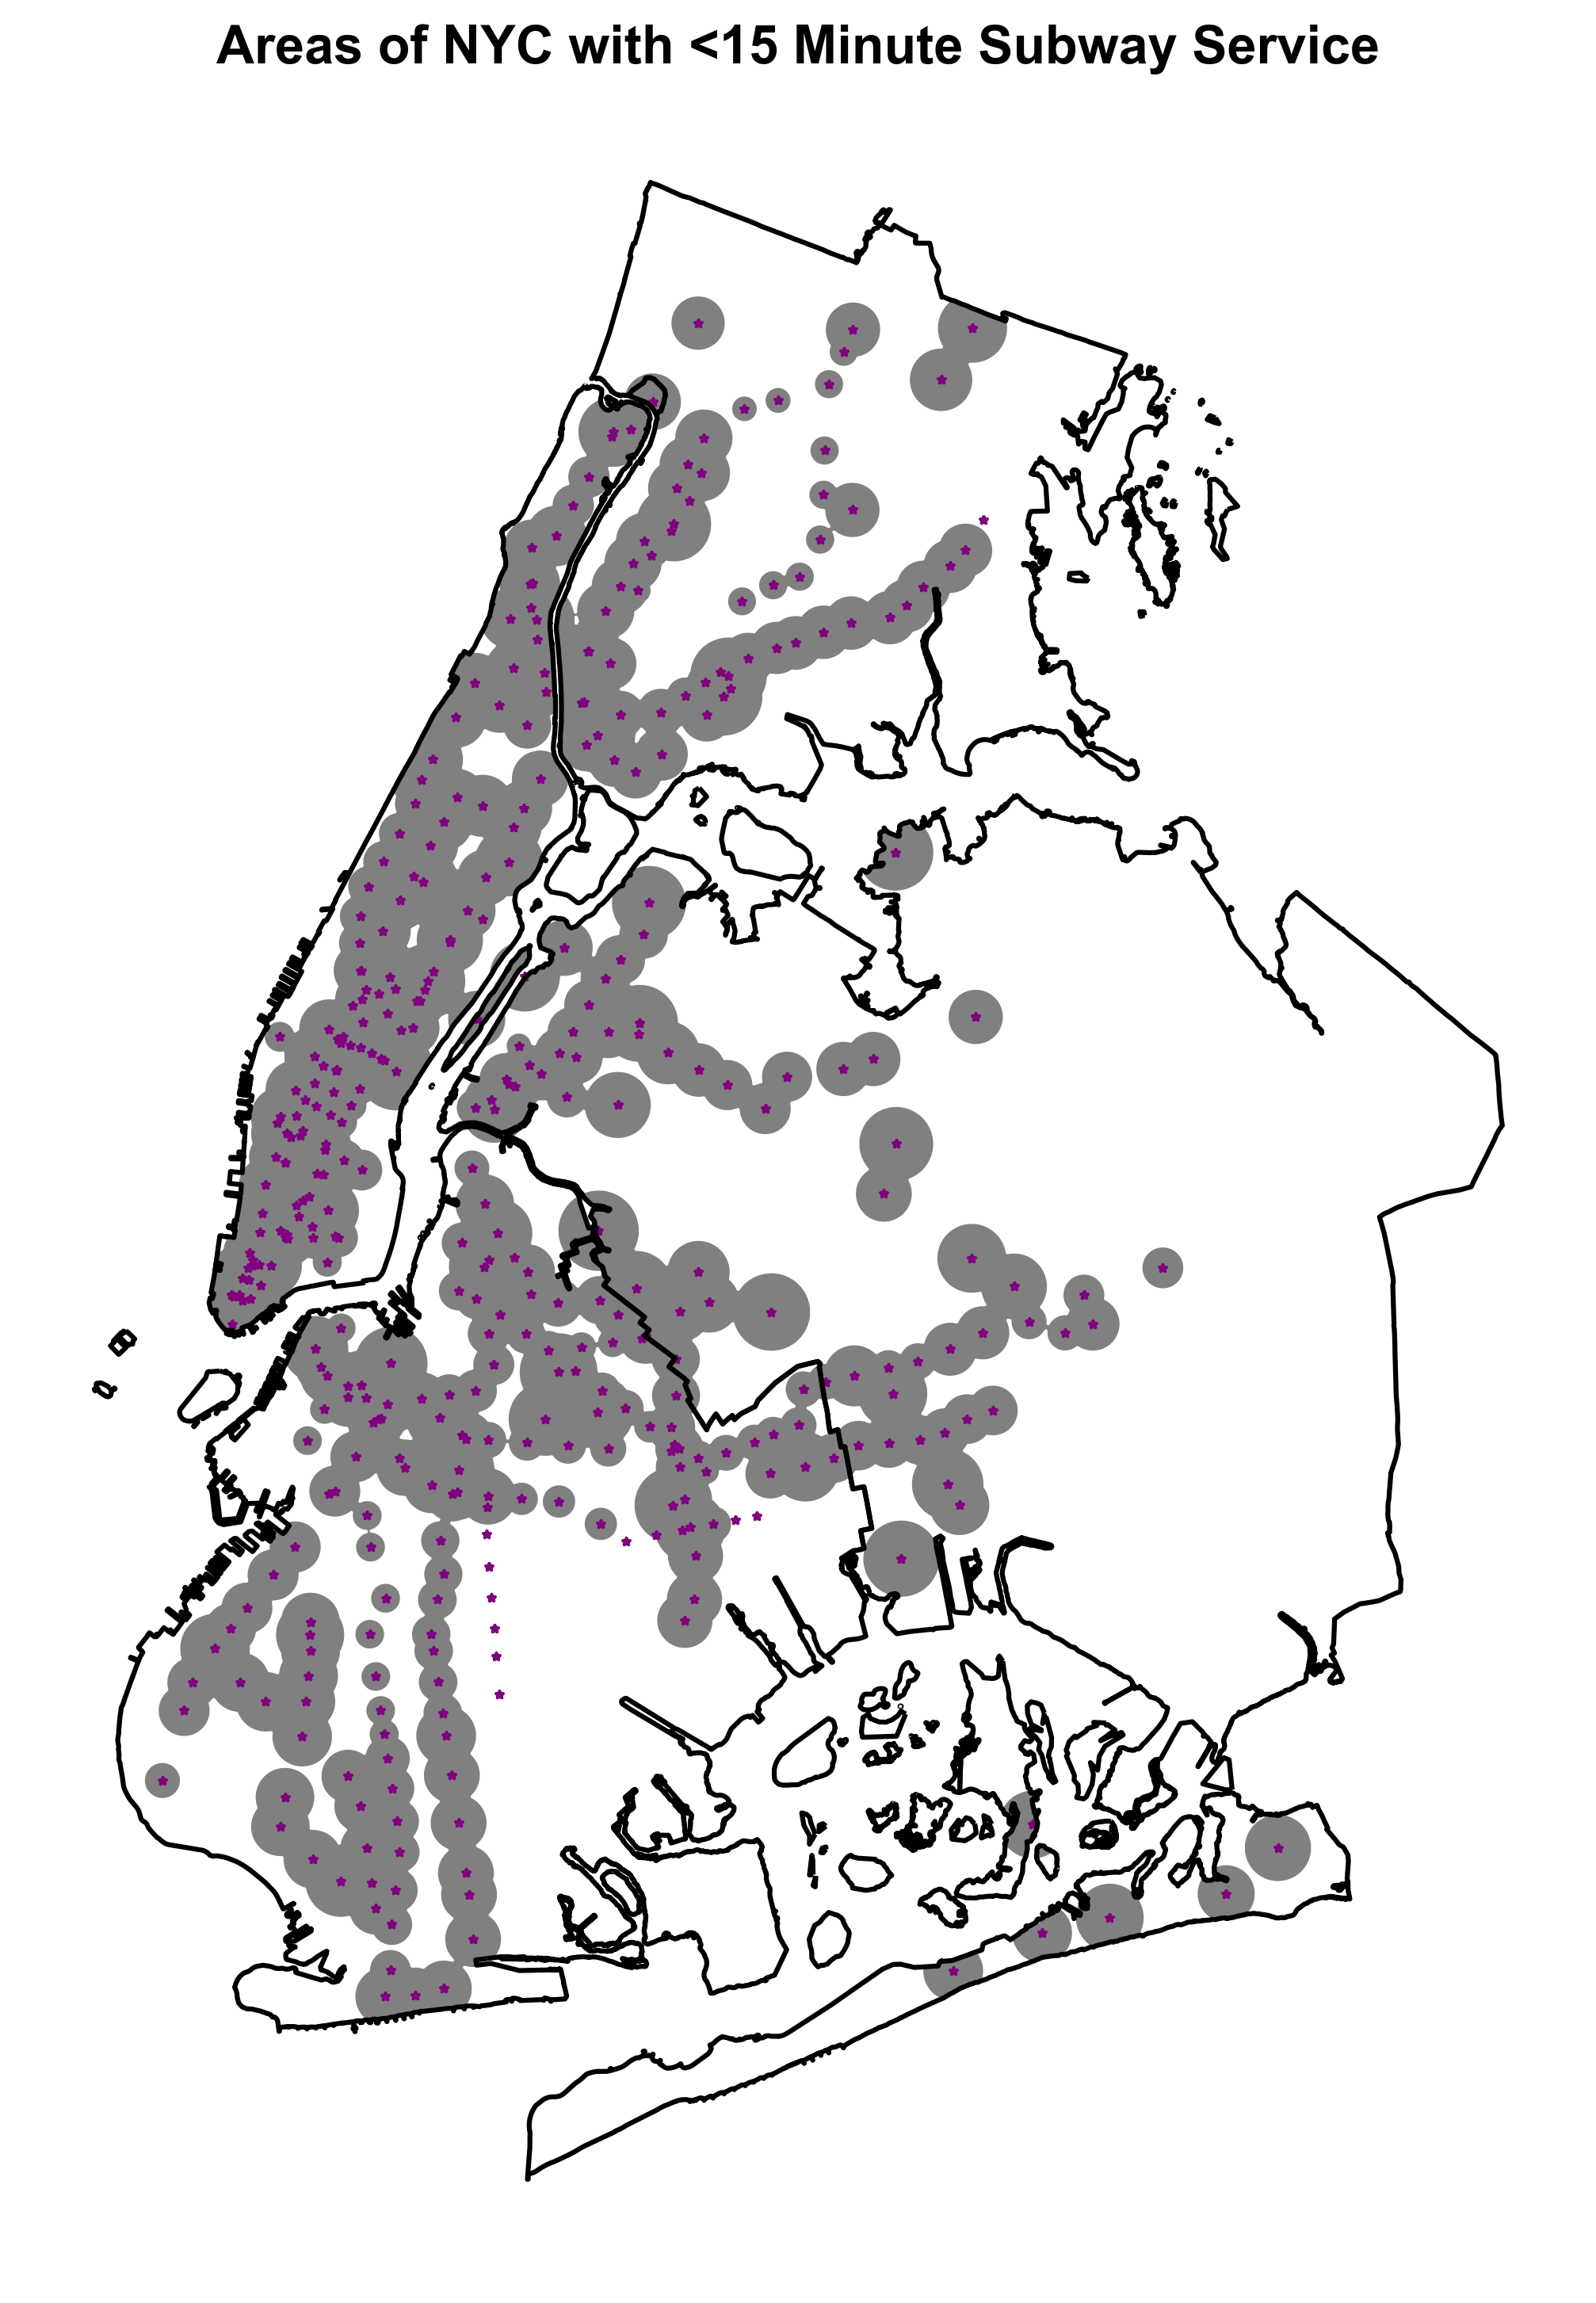

In [22]:
fig, ax = plt.subplots(figsize=(12,12))
ax.axis('off')
ax.set_title("Areas of NYC with <15 Minute Subway Service", color='black', fontsize=16, weight='bold')
boros.boundary.plot(ax=ax, color="black")
# stations_geodataframe_final.plot(color='lightgray', ax=ax)
common_area.plot(color='grey', ax=ax)
# stations
complex_geodataframe['geometry'].plot(marker='*', color='purple', markersize=5, ax=ax)

In [23]:
complex_geodataframe

,Complex ID,geometry,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,stations_in_complex_count,...,hourly_trainset_area,capacity,mean_wait_time,Late Night,Weekend,Rush Hour AM,Midday,Rush Hour PM,Evening,TPH_percent_rank
0,1,POINT (-8227379.441 4985311.546),R01,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,1,...,"5,496","1,309",6,3,5,12,13,13,8,0
1,2,POINT (-8228487.07 4985255.504),R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,1,...,"5,496","1,309",6,3,5,12,13,13,8,0
2,3,POINT (-8229484.604 4985593.965),R04,BMT,Astoria,30 Av,Q,N W,Elevated,1,...,"5,496","1,309",6,3,5,12,13,13,8,0
3,4,POINT (-8230570.191 4986398.609),R05,BMT,Astoria,Broadway,Q,N W,Elevated,1,...,"5,507","1,311",6,3,5,12,13,13,8,0
4,5,POINT (-8230545.145 4985889.778),R06,BMT,Astoria,36 Av,Q,N W,Elevated,1,...,"5,505","1,311",6,3,5,12,13,13,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,628,POINT (-8224338.276 4968835.699),229418A38M22,IRTIRTINDBMT,Clark StLexington Av8th Av - Fulton StJamaica,Fulton StFulton StFulton StFulton St,MMMM,2 34 5A CJ Z,SubwaySubwaySubwaySubway,16,...,"24,766","5,897",18,15,39,71,62,70,44,3
420,629,POINT (-8231117.995 4978063.688),G29L10,INDBMT,CrosstownCanarsie,Metropolitan AvLorimer St,BkBk,GL,SubwaySubway,4,...,"9,581","2,281",9,10,24,31,27,29,24,1
421,630,POINT (-8233178.407 4979057.786),L17M08,BMTBMT,CanarsieMyrtle Av,Myrtle-Wyckoff AvsMyrtle-Wyckoff Avs,BkBk,LM,SubwayElevated,4,...,"8,972","2,136",14,7,18,23,21,22,18,1
422,635,POINT (-8233456.762 4965921.366),142R27,IRTBMT,Broadway - 7AvBroadway,South FerryWhitehall St-South Ferry,MM,1R W,SubwaySubway,4,...,"10,378","2,471",11,10,14,26,24,28,20,1


## GIF using normal geopandas plot 

In [24]:
output_path = "../saved_data/x_minute_city_gif/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [25]:
for idx, number in enumerate(range(0, 310, 25)):
    number = number / 10 # adjusting for the multiplication needed to make the range function to work 
    # making the number integers (if possible)
    if int(number) != number:
        pass 
    else:
        number = int(number)
    # distance data 
    new_stations_geodataframe = complex_geodataframe.copy()
    new_stations_geodataframe[f'distance_in_{number}'] = x_minute_subway(complex_geodataframe, number)
    new_stations_geodataframe['geometry'] = new_stations_geodataframe['geometry'].buffer(
                                            new_stations_geodataframe[f'distance_in_{number}'])
    
    common_area = boros['geometry'].intersection(new_stations_geodataframe['geometry'].unary_union)
    difference_area = boros['geometry'].difference(new_stations_geodataframe['geometry'].unary_union)
    
    fig, ax = plt.subplots(figsize=(12,12))
    ax.axis('off')
    if number == 0:
        ax.set_title(f"NYC Subway Stations", color='black', fontsize=16, weight='bold')
    else:
        ax.set_title(f"Areas of NYC with <{number} Minute Subway Service", color='black', fontsize=16, weight='bold')
    boros.boundary.plot(ax=ax, color="black")
    # common_area.plot(color='grey', edgecolor='purple', ax=ax)
    difference_area.plot(color='grey', edgecolor='purple', ax=ax)   
    # stations
    complex_geodataframe['geometry'].plot(marker='*', color='purple', markersize=5, ax=ax)
    if idx >= 10:
        idx = 'a' + str(idx)
    filepath = os.path.join(output_path, str(idx) + '_' + str(number) + '_minute_city' + ".png")
    plt.savefig(filepath, bbox_inches='tight')
    plt.close()

In [26]:
images = []
for file_name in sorted(glob.glob(f'{output_path}/*.png')):
    images.append(imageio.imread(file_name))
# for file_name in sorted(glob.glob(f'{output_path}/*.png'), reverse=True):       # adding the images in reverse order too 
#     images.append(imageio.imread(file_name))
imageio.mimsave(f'{output_path}/movie.gif', images, fps=0.9)